In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import requests

In [2]:
tg_api_token = '5102696637:AAHcm9cOmIF7-GyG7nHHJYA_yZCGSWSTu60'
tg_chat_id = '1126129331'

def send_tg_message(text='Cell execution completed.'):
    requests.post(
        'https://api.telegram.org/' +
        'bot{}/sendMessage'.format(tg_api_token), 
        params=dict(chat_id=tg_chat_id, text=text)
    )

In [3]:
def plot_signal_label(df, sample_rate=700):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
    df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)
    # df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ACC_X", "label_id"], ax=ax6)
    # df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ACC_Y", "label_id"], ax=ax7)
    # df[::sample_rate].plot(figsize=(30, 30), grid=True, y=["ACC_Z", "label_id"], ax=ax8)

In [4]:
def print_distributions_of_labels(labels_np):
    unique_values, counts = np.unique(labels_np, axis=0, return_counts=True)
    print(f"{unique_values} {counts}")
    print(f"{unique_values} {counts/sum(counts)}")

# Get Normalized Data

In [5]:
f=open("cleaned_data",'rb')
data=pickle.load(f,encoding='latin1')
clean_chest_data = data["cleaned_data"]

In [6]:
len(clean_chest_data), len(clean_chest_data[-1])

(15, 3)

In [7]:
clean_chest_data[-1][0].describe().T

,count,mean,std,min,25%,50%,75%,max
ECG,36764.0,-0.000072,0.999438,-2.765331,-0.356705,-0.065254,0.079238,6.481377
EMG,36764.0,-0.000474,1.034653,-9.015484,-0.487459,0.019321,0.497828,16.285641
EDA,36764.0,-1.057305,1.025039,-13.936428,-1.669384,-1.226798,-0.682242,11.142245
Temp,36764.0,-0.302484,1.267106,-6.932573,-1.133732,-0.319611,0.539562,7.927171
Resp,36764.0,-0.002043,1.058039,-6.038162,-0.576340,-0.056633,0.616001,6.656630


In [8]:
validation_plot_df = pd.concat([clean_chest_data[-1][0].reset_index(), pd.DataFrame(clean_chest_data[-1][1], columns=["label_id"])], axis=1, join="inner")

In [9]:
validation_plot_df

,index,ECG,EMG,EDA,Temp,Resp,label_id
0,0,-0.072189,-0.819432,-0.936136,-0.920856,0.147186,0
1,100,0.188132,-0.082813,0.605367,-1.196914,0.036745,0
2,200,-0.182575,-1.610557,-1.333514,-1.384016,0.051367,0
3,300,-0.914864,-1.200728,-1.563277,-2.163917,0.163402,0
4,400,-1.016232,0.332929,-1.827169,-1.123056,0.235620,0
...,...,...,...,...,...,...,...
36759,3675900,-1.099367,-0.240547,0.456864,-0.942645,1.583176,0
36760,3676000,-0.523468,0.134308,0.446952,-1.371586,1.167397,0
36761,3676100,0.034424,1.000172,0.565896,-0.684937,0.768383,0
36762,3676200,0.073596,-0.459652,0.427128,-0.727746,0.383390,0


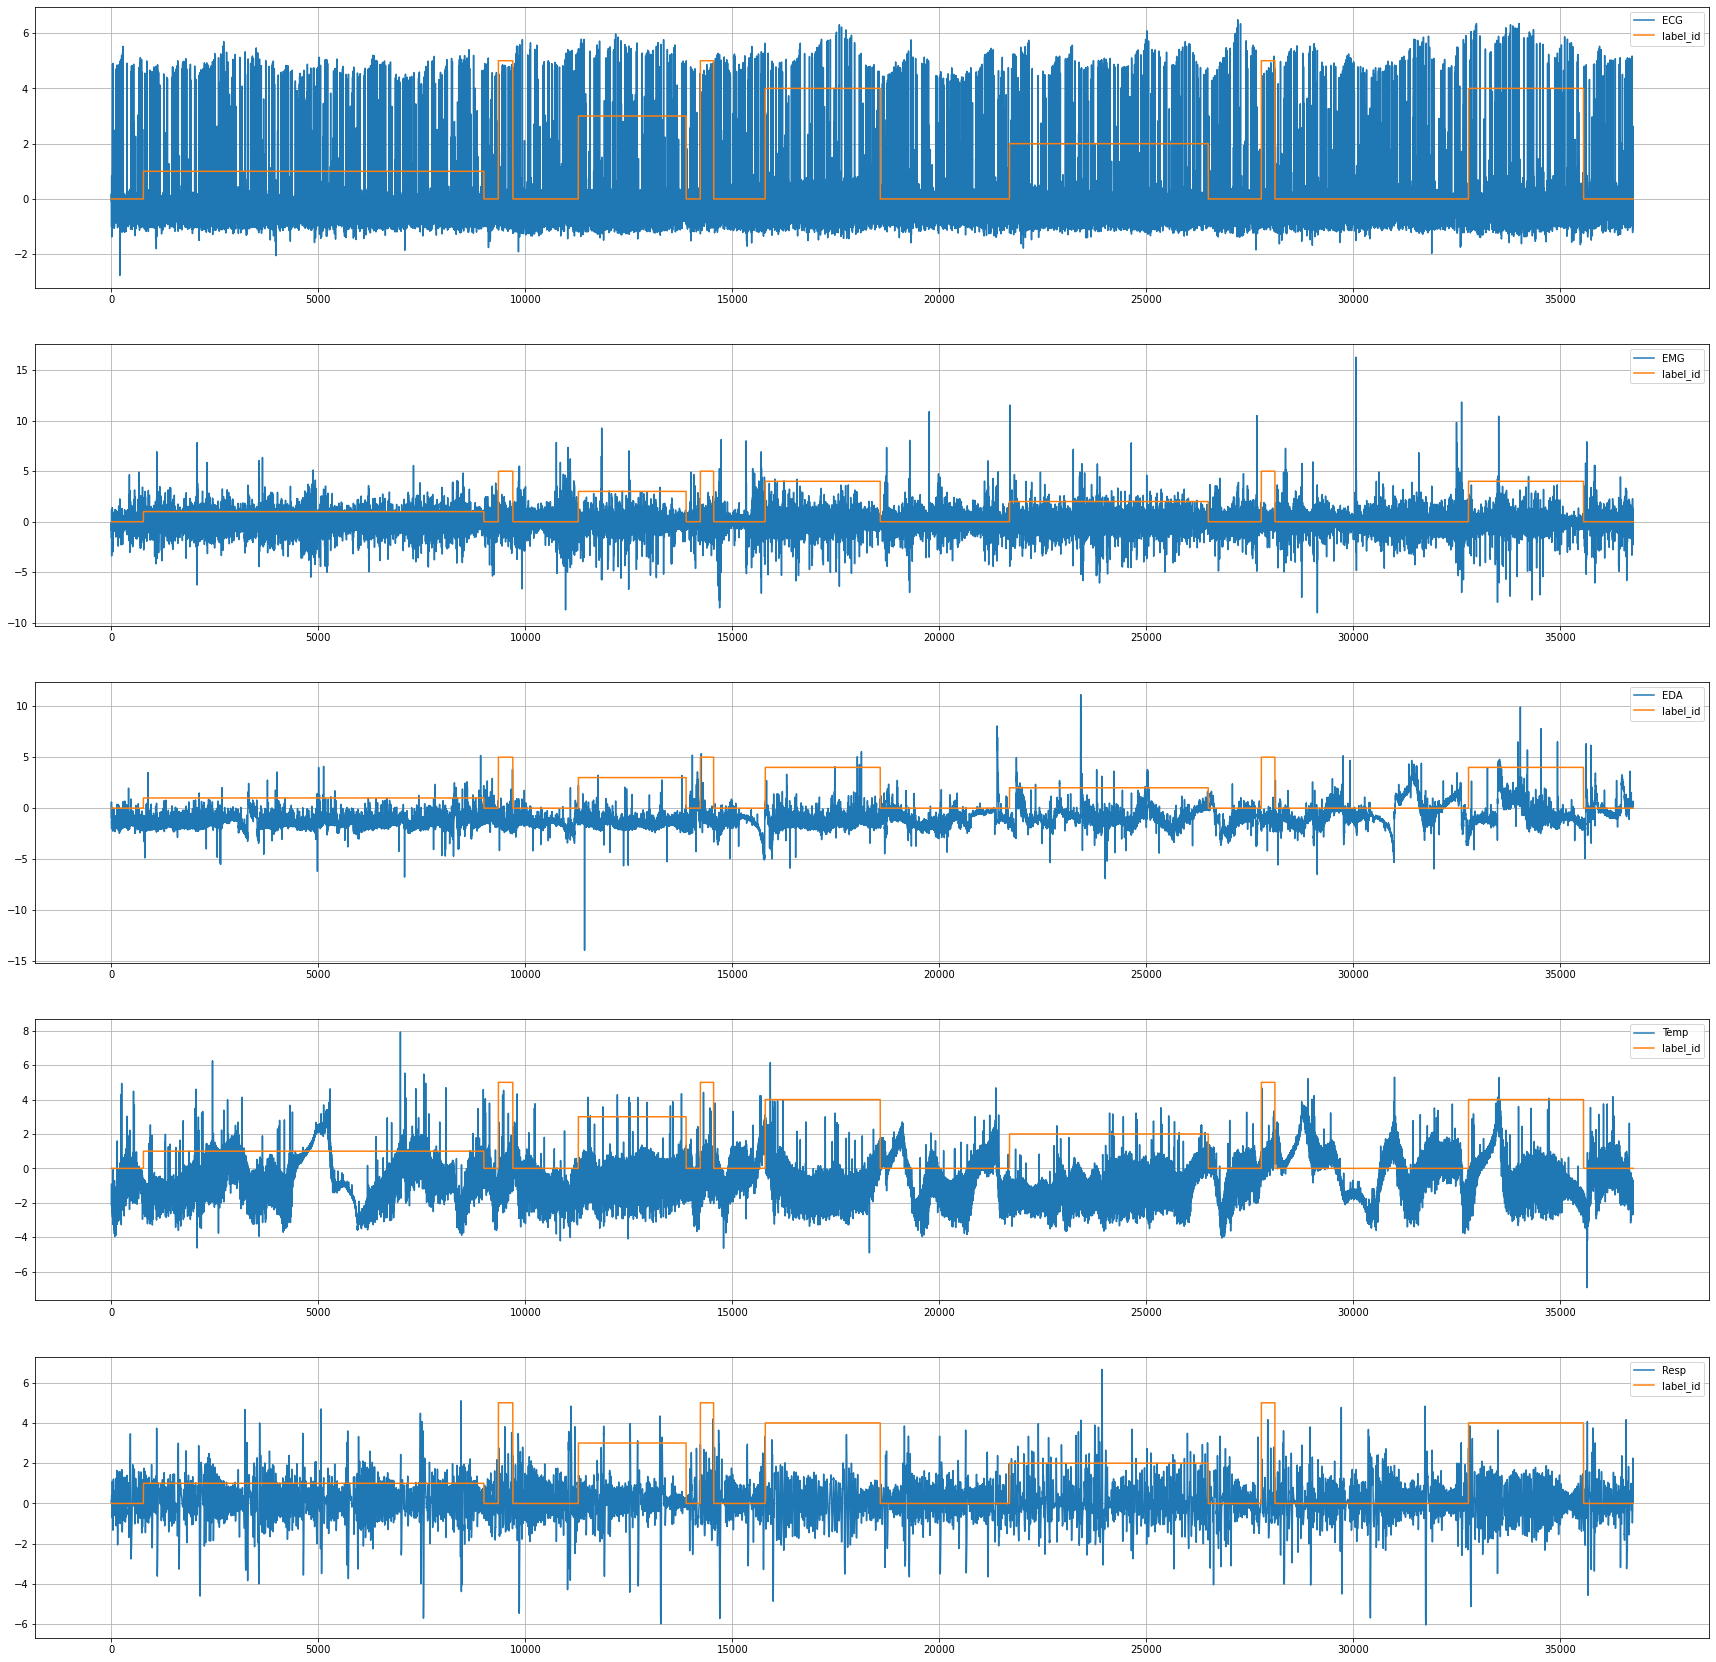

In [10]:
plot_signal_label(validation_plot_df, None)

In [11]:
win_size = (90*700)//100
step_slinding_window = 100

In [12]:
clean_chest_data[-1][1].shape, clean_chest_data[-1][2]

((36764,), 'S15')

In [13]:
print_distributions_of_labels(clean_chest_data[-1][1])

[0 1 2 3 4 5] [14574  8225  4802  2604  5558  1001]
[0 1 2 3 4 5] [0.39642041 0.2237243  0.13061691 0.07083016 0.1511805  0.02722772]


# Get Features and Targets for Trainnig and Validation

In [14]:
def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    percentage_of_elements = counts/sum(counts)
    return unique[most_repeted_element_index[0][0]] , percentage_of_elements[most_repeted_element_index[0][0]]


def get_features_and_targets(features_np_array, targets_np_array, win_size = 60, step_slinding_window = 1, freq_threshold=0.60, verbose=False):
    
    features = []
    targets = []
    elemets_debug = []

    features_aux, targets_aux = features_np_array, targets_np_array
    
    print(f"\nWindow Size: {win_size}, Sliding Step: {step_slinding_window}. Counter Label Threshold: {freq_threshold}\n\n")
    
    for i in range(len(targets_np_array) - win_size + 1):
        
        if verbose:
            print(f"Window {i}", end="\r", flush=True)
        
        slicer = slice(i, win_size + i)
        
        feature_window = features_aux[slicer]
        target_window = targets_aux[slicer]
        
        element, element_freq = get_most_repeted_element(target_window)
        elemets_debug.append((element, element_freq))
        
        if element_freq >= freq_threshold:
            features.append(feature_window)
            targets.append(element)
    
    return np.array(features), np.array(targets), elemets_debug

In [15]:
print_distributions_of_labels(clean_chest_data[0][1])

[0 1 2 3 4 5] [21427  8386  4515  2618  5558  1302]
[0 1 2 3 4 5] [0.48913391 0.19143496 0.10306807 0.0597635  0.1268776  0.02972196]


In [16]:
features_test, targets_test, elements_debug = get_features_and_targets(clean_chest_data[0][0].to_numpy(), clean_chest_data[0][1], win_size=win_size, step_slinding_window=step_slinding_window)

send_tg_message("Terminou de gerar as janelas de Teste")


Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




In [17]:
print_distributions_of_labels(targets_test)

[0 1 2 3 4 5] [19643  8261  4390  2493  5308   744]
[0 1 2 3 4 5] [0.48098631 0.20228213 0.10749529 0.06104459 0.1299738  0.01821788]


In [18]:
features_test.shape, targets_test.shape

((40839, 630, 5), (40839,))

## Get Validation Data

In [19]:
validation_data = clean_chest_data.pop()

In [20]:
validation_data[2]

'S15'

In [21]:
print_distributions_of_labels(validation_data[1])

[0 1 2 3 4 5] [14574  8225  4802  2604  5558  1001]
[0 1 2 3 4 5] [0.39642041 0.2237243  0.13061691 0.07083016 0.1511805  0.02722772]


In [22]:
validation_features, validation_targets, _ = get_features_and_targets(validation_data[0].to_numpy(), validation_data[1], win_size=win_size, step_slinding_window=step_slinding_window)

send_tg_message("Terminou de Gerar os Dados de Validação")


Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




In [23]:
validation_features.shape, validation_targets.shape

((33066, 630, 5), (33066,))

In [24]:
print_distributions_of_labels(validation_targets)

[0 1 2 3 4] [12502  8100  4677  2479  5308]
[0 1 2 3 4] [0.3780923  0.24496462 0.14144438 0.07497127 0.16052743]


## Get Training Data

In [25]:
features = []
targets = []
i = 0

for data in clean_chest_data:
    
    print(f"\n\nJoinning Window of Subject {data[2]}\n\n")
    send_tg_message(f"Joinning Window of Subject {data[2]}, we have {len(clean_chest_data) - i} to go.")
    i = i + 1

    subject_features, subject_targets, _ = get_features_and_targets(data[0].to_numpy(), data[1], win_size=win_size, step_slinding_window=step_slinding_window)
    features.append(subject_features)
    targets.append(subject_targets)

    del subject_features
    del subject_targets
    del data

    gc.collect()

del clean_chest_data
gc.collect()

features = np.concatenate(tuple(features), axis=0)
targets = np.concatenate(tuple(targets), axis=0)

send_tg_message("Terminou carai!")



Joinning Window of Subject S5



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S2



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S3



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S4



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S17



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S10



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S11



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S16



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S8



Window Size: 630, Sliding Step: 100. Counter Label Threshold: 0.6




Joinning Window of Subject S6



Window Size: 630, Sliding Step: 10

In [26]:
features.shape, targets.shape

((528217, 630, 5), (528217,))

In [27]:
data_to_save = {
    "trainning_data_features": features,
    "trainning_data_targets": targets,
    "validation_data_features": validation_features,
    "validation_data_targets": validation_targets
}

In [28]:
with open("input_model_data", 'wb') as f:
    pickle.dump(data_to_save, f)
    
send_tg_message("Terminou de salvar os dados também!!")